This Notebook reads in a mp4 video, with a resolution of 848x480. Currently no other format and no other resolution are supported.
Each frame of the video will be stored. A watermark will be added to every frame and these frames also will be stored.
Then the watermarked and the original(pure) frames will be split into a desired number.
The reason for that is that my GPU only owns 4GB. So by reducing the the input size I can increase my model size. 

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline   
from glob import glob
import PIL

The two png-files were created with the same resolution as the video: 848x480.
So for the first step no image carving, streching, etc. will be necessary.
Currently this project only works with videos with a resolution of 848x480!!!

In [4]:
#path to videos folder
path_mp4_videos = ".\\video_input\\*.mp4"
#build a list that contains all pathes of video files in the specified folder
list_videos = glob(path_mp4_videos)
#find out number of videos; and how many frames per video will be generated
#necessary information for building the name-index of each frame
#Hint: That's done for a better sorting.
#Reason: frame100.jpg is before frame50.jpg
#--> turn frame50.jpg into frame050.jpg
videos_count = len(list_videos)
#find max_count of frames of all videos
max_count_frames = 0
for video_path in list_videos:
    video = cv2.VideoCapture(video_path)
    count_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    if count_frames > max_count_frames:
        max_count_frames = count_frames
    
print (len(list_videos))
print (list_videos[0])

path_datafolder_pureimage = ".\\targets\\"
path_datafolder_watermarked = ".\\inputs\\"

#if the folder doesn't exist, create one
if not os.path.exists(path_datafolder_pureimage):
    os.makedirs(path_datafolder_pureimage)
if not os.path.exists(path_datafolder_watermarked):
    os.makedirs(path_datafolder_watermarked)

3
.\video_input\Mein Video.mp4


__Below:__ A random damaged frame 

![blend1_0180.png](blend1_0180.png)

__Below:__ And the corresponding original frame

 ![frame1_0180.png](frame1_0180.png)

Create the mask for the black bars

In [5]:
s =  (np.zeros((480,848,3), dtype=np.uint8))
horizontal_black_bar=[]

every_x_row = 10
for i in range(480):
    if i%every_x_row == 0:
        horizontal_black_bar.append(i)
        
for row_index,row in enumerate(s):
    for col_index,col in enumerate(row):
        for layer_index,layer in enumerate(col):
            #print(row)
            if row_index in horizontal_black_bar:
                s[row_index][col_index][layer_index] = 255

#uncomment if mask should be saved                
#s_to_PIL = PIL.Image.fromarray(s)
#s_to_PIL.save("./blackbars.png") 

In [7]:
#Number of digits for video count
digits_video_index = int(len(str(videos_count)))
digits_frames_index = int(len(str(max_count_frames)))
#s_im = Image.fromarray(s)

for video_index,video in enumerate (list_videos,1):
    frame_index = 0
    cap = cv2.VideoCapture(video)
    while(cap.isOpened()):
        frame_index += 1
        ret, image = cap.read()
        if ret == True:
            dst = cv2.subtract(image,s)
            #transform for example 1 --> 001
            video_index_tr = "{{0:0{}}}".format(digits_video_index).format(video_index)
            frames_index_tr = "{{0:0{}}}".format(digits_frames_index).format(frame_index)
            #
            cv2.imwrite(path_datafolder_pureimage+"frame"+str(video_index_tr)+"_"+str(frames_index_tr)+".png",image)
            cv2.imwrite(path_datafolder_watermarked+"blend"+str(video_index_tr)+"_"+str(frames_index_tr)+".png",dst)
        else:
            break


__Split image into pieces:__
Since I'm using a GPU with 4GB RAM the deapth of my model is limited. So I'll split one image into 4 subimages

In [8]:
count_pieces = 4

if not os.path.exists(path_datafolder_pureimage+"split"):
    os.makedirs(path_datafolder_pureimage+"split")
if not os.path.exists(path_datafolder_watermarked+"split"):
    os.makedirs(path_datafolder_watermarked+"split")

The Parameters of the next codeblock must be adapt to the used imagesize

In [9]:
for im in  glob(path_datafolder_pureimage+"*.png"):
    im2split = cv2.imread(im)
    imname = im[im.find("frame"):im.rfind(".")]
    width_splint = int(848/count_pieces) #width of input is always 848 in this project
    for i in range(count_pieces):
        if i == (count_pieces-1): #last splint
            cv2.imwrite(path_datafolder_pureimage+"split\\"+imname+"_"+str(i+1)+".png",im2split[:,(width_splint*i):,:])
        else:
            cv2.imwrite(path_datafolder_pureimage+"split\\"+imname+"_"+str(i+1)+".png",im2split[:,(width_splint*i):(width_splint*i)+width_splint,:]) 
        

In [10]:
for im in  glob(path_datafolder_watermarked+"*.png"):
    im2split = cv2.imread(im)
    imname = im[im.find("blend"):im.rfind(".")]
    width_splint = int(848/count_pieces) #width of input is always 848 in this project
    for i in range(count_pieces):
        if i == (count_pieces-1): #last splint
            cv2.imwrite(path_datafolder_watermarked+"split\\"+imname+"_"+str(i+1)+".png",im2split[:,(width_splint*i):,:])
        else:
            cv2.imwrite(path_datafolder_watermarked+"split\\"+imname+"_"+str(i+1)+".png",im2split[:,(width_splint*i):(width_splint*i)+width_splint,:]) 
 

Check if everything went right:

.\inputs\blend1_0010.png
\blend1_0010


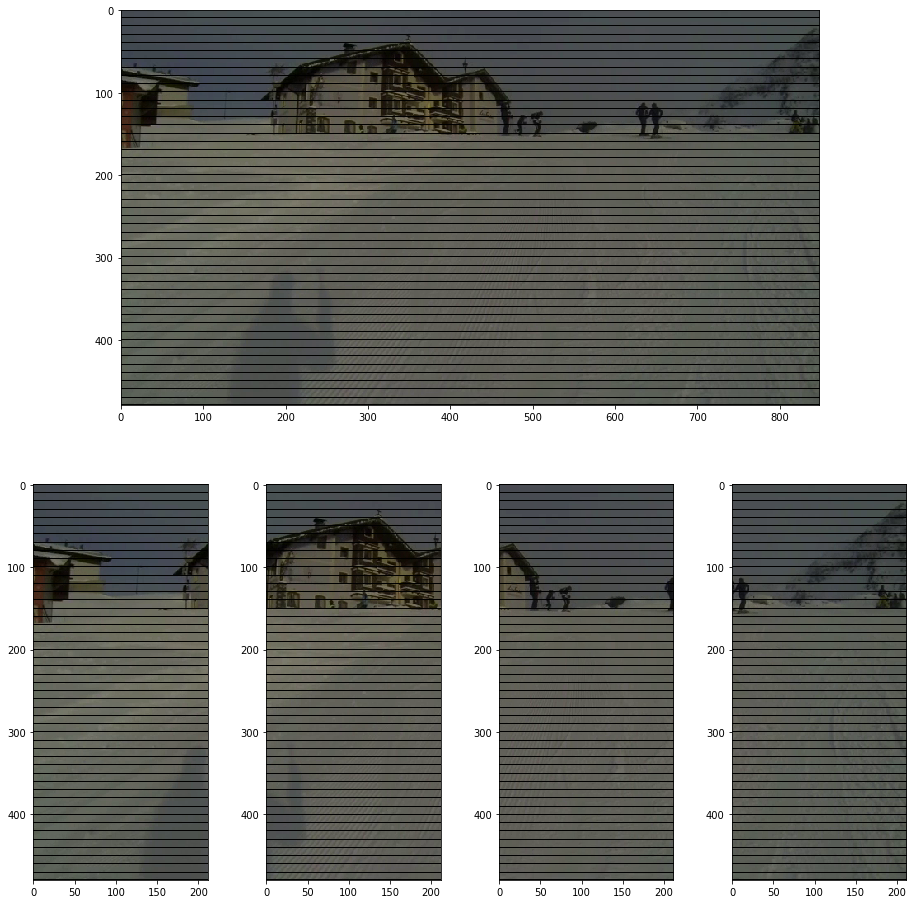

In [11]:
##print
video_index_tr = "{{0:0{}}}".format(digits_video_index).format(1)
frames_index_tr = "{{0:0{}}}".format(digits_frames_index).format(10)
wm1 = path_datafolder_watermarked+"blend"+str(video_index_tr)+"_"+str(frames_index_tr)+".png"
wm1_without_path = wm1[wm1.rfind("\\"):wm1.rfind(".")]
wm_list = []
print(wm1)
print(wm1_without_path)
for i in range(1,count_pieces+1):
    for im in glob(path_datafolder_watermarked+"split\\"+wm1_without_path+"_"+str(i)+".png"):
        wm_list.append(im)
        break
    
wm1_RGB = cv2.cvtColor(cv2.imread(wm1), cv2.COLOR_BGR2RGB)
splitter_list = []

for im in wm_list:
    splitter_list.append(cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB))


fig = plt.figure(figsize=(16,16))

gs1 = GridSpec(2, 4)
ax1 = fig.add_subplot(gs1[:1, :])
plt.imshow(wm1_RGB)
for split in range(count_pieces):
    ax = fig.add_subplot(gs1[1:,split:split+1])
    plt.imshow(splitter_list[split])

plt.show()  

__Conclusion__:  
So now wo have for every frame of the original video, the original frame split into 4 pieces and the same frame added with a (watermark)noise and split into 4 pieces of the same size.  
So for the CNN we have the inputs with the corresponding targets.  
In the next notebook, I build a CNN and train it.